In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")

In [3]:
ground_truth = np.load("/data/azure-windows-ts-array-ground-truth.npy")
predictions = np.load("/data/azure-full-predictions.npy")

In [4]:
ground_truth.shape, predictions.shape

((275077, 8639), (275077, 8639))

In [5]:
np.isnan(ground_truth).sum(), np.isnan(predictions).sum()

(525466614, 754088333)

In [6]:
masked_ground_truth = ground_truth.copy()
np.place(masked_ground_truth, mask=np.isnan(predictions), vals=np.nan)

In [7]:
(np.isnan(masked_ground_truth).sum() - np.isnan(predictions).sum())/275077

27.510780617790655

In [8]:
(np.isnan(ground_truth).sum() - np.isnan(predictions).sum())/275077

-831.1189921367471

In [9]:
y_true = np.nan_to_num(masked_ground_truth, 0.0)
y_pred = np.nan_to_num(predictions, 0.0)

In [10]:
from sktime.performance_metrics.forecasting import mean_squared_scaled_error
from multiprocessing import Pool
from tqdm import tqdm

def error_func(i):
    y_true_, y_pred_ = y_true[i], y_pred[i]
    return mean_squared_scaled_error(y_true_, y_pred_, sp=288, y_train=y_true_)

assert y_true.shape == y_pred.shape

with Pool() as p:
    msse = list(tqdm(p.imap(error_func, range(len(y_true)), chunksize=64), total=len(y_true)))

100%|██████████| 275077/275077 [00:02<00:00, 99060.39it/s] 


In [16]:
import duckdb

conn = duckdb.connect("/home/ubuntu/azure_long_series_with_ts_array.duckdb", read_only=True)
conn.execute("PRAGMA enable_progress_bar")
num_windows_df = conn.execute("""
SELECT int_id, (timestamp[-1] - timestamp[1]+1)/288-2 as num_windows
  FROM readings
ORDER BY int_id ASC
""").df()

100% [============================================================] 
100% [============================================================] 


In [23]:
final_score = (msse / num_windows_df["num_windows"]).mean()
final_score

0.8850164730987755

In [25]:
np.array(msse).mean()

2.0844151659896957

In [23]:
start_idx_df = pd.read_parquet("~/ts_start_end_idx")

In [24]:
start_idx_df

,int_id,start_idx,end_idx
0,0,1861,5579
1,1,0,8638
2,2,3976,4862
3,3,0,8638
4,4,0,8638
...,...,...,...
275072,275289,0,8638
275073,275290,0,8638
275074,275291,0,2914
275075,275292,0,8638


In [6]:
def plot_ts(pred, label):
    pd.Series(label).rolling(12).mean().plot(label="label")
    pd.Series(pred).rolling(12).mean().plot(label="pred", alpha=0.8)
    plt.legend()

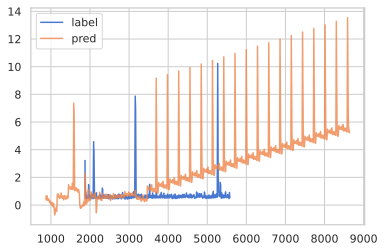

In [10]:
plot_ts(predictions[0], ground_truth[0])

In [17]:
s = np.isnan(predictions).sum(axis=0)
s

array([275077, 275077, 275077, ...,      0,      0,      0])

In [18]:
s.sum()/275077

864.0

In [11]:
import pandas as pd

In [12]:
d = pd.read_parquet("/data/azure-windows/0.parquet")

In [13]:
d

,int_id,start_idx,window_arr,forecast_arr
0,0,0,"[19.33655, 3.25558, 1.5101819, 1.2159386, 6.02...","[-2.3292916, 0.049764298, 0.3185127, 0.5560014..."
1,0,288,"[0.47625303, 0.45383844, 0.47115472, 1.0710546...","[0.46752152, 0.4842767, 0.44538835, 0.43466362..."
2,0,576,"[0.48136094, 0.46038508, 0.46710244, 0.4866589...","[1.1095917, 1.1308558, 1.1144993, 1.1315572, 1..."
3,0,864,"[0.42231634, 0.44957128, 0.4031213, 0.48989177...","[-0.29055426, -0.2564476, -0.26887843, -0.2516..."
4,0,1152,"[0.45031497, 0.44427052, 0.4520993, 0.44245595...","[0.58667684, 0.8410064, 0.5313397, 1.2051592, ..."
5,0,1440,"[0.4593224, 0.517726, 0.48565444, 0.5234886, 1...","[0.75230145, 0.51346654, 0.45920786, 1.0029172..."
6,0,1728,"[0.49255922, 0.7543771, 0.41228858, 1.1869009,...","[0.7322177, 0.74312484, 0.5144674, 0.5921977, ..."
7,0,2016,"[0.8291027, 0.4637525, 0.51596385, 0.88870746,...","[0.7180559, 0.7199522, 0.63806355, 0.65026593,..."
8,0,2304,"[0.6312334, 0.8260335, 0.47510877, 0.5732621, ...","[0.3212567, 0.27693954, 0.3558344, 0.39178813,..."
9,0,2592,"[0.6045058, 0.4888383, 0.5185874, 0.5667438, 1...","[1.3981472, 1.1398147, 1.1181014, 1.232592, 1...."


In [28]:
ground_truth = np.nan_to_num(ground_truth, copy=False, nan=0)

In [29]:
mse_mat = (ground_truth - predictions)**2

In [30]:
mse_per_timestamp = mse_mat.mean(axis=0)
mse_per_timestamp_weighted = mse_mat.sum(axis=0)/np.count_nonzero(mse_mat, axis=0)
mse_per_key = mse_mat.mean(axis=1)
mse_per_key_weighted = mse_mat.sum(axis=1)/np.count_nonzero(mse_mat, axis=1)

In [31]:
mse_per_timestamp.mean(), mse_per_key.mean(), mse_per_key_weighted.mean(), mse_per_timestamp_weighted.mean()

(nan, nan, nan, nan)